# 2つの正規分布の直積モデルのベイズ統計によるWelchのt検定の再現

* 黒木玄
* 2022-09-16

2つの正規分布の直積モデルのベイズ統計でWelchのt検定が近似的に再現されることを確認する.

In [1]:
using Distributions
using QuadGK
using Random
Random.seed!(4649373)
using StatsBase: ecdf
using StatsPlots
default(fmt=:png, titlefontsize=10, plot_titlefontsize=10)

distname(dist) = replace(string(dist), r"{[^}]*}"=>"")

distname (generic function with 1 method)

In [2]:
# 通常のWelchのt検定

function tvalue_welch(m, x̄, sx², n, ȳ, sy²; Δμ=0)
    (x̄ - ȳ - Δμ) / √(sx²/m + sy²/n)
end

function tvalue_welch(x, y; Δμ=0)
    m, x̄, sx² = length(x), mean(x), var(x)
    n, ȳ, sy² = length(y), mean(y), var(y)
    tvalue_welch(m, x̄, sx², n, ȳ, sy²; Δμ)
end

function degree_of_freedom_welch(m, sx², n, sy²)
    (sx²/m + sy²/n)^2 / ((sx²/m)^2/(m-1) + (sy²/n)^2/(n-1))
end

function degree_of_freedom_welch(x, y)
    m, sx² = length(x), var(x)
    n, sy² = length(y), var(y)
    degree_of_freedom_welch(m, sx², n, sy²)
end

function pvalue_welch(m, x̄, sx², n, ȳ, sy²; Δμ=0)
    t = tvalue_welch(m, x̄, sx², n, ȳ, sy²; Δμ)
    ν = degree_of_freedom_welch(m, sx², n, sy²)
    2ccdf(TDist(ν), abs(t))
end

function pvalue_welch(x, y; Δμ=0)
    m, x̄, sx² = length(x), mean(x), var(x)
    n, ȳ, sy² = length(y), mean(y), var(y)
    pvalue_welch(m, x̄, sx², n, ȳ, sy²; Δμ)
end

function confint_welch(m, x̄, sx², n, ȳ, sy²; α=0.05)
    ν = degree_of_freedom_welch(m, sx², n, sy²)
    c = quantile(TDist(ν), 1-α/2)
    SEhat = √(sx²/m + sy²/n)
    [x̄-ȳ-c*SEhat, x̄-ȳ+c*SEhat]
end

function confint_welch(x, y; α=0.05)
    m, x̄, sx² = length(x), mean(x), var(x)
    n, ȳ, sy² = length(y), mean(y), var(y)
    confint_welch(m, x̄, sx², n, ȳ, sy²; α)
end

confint_welch (generic function with 2 methods)

In [3]:
# Welchのt検定を正確に再現する Δμ に関する分布

function posterior_welch(m, x̄, sx², n, ȳ, sy²)
    ν = degree_of_freedom_welch(m, sx², n, sy²)
    SEhat = √(sx²/m + sy²/n)
    x̄ - ȳ + SEhat*TDist(ν)
end

function posterior_welch(x, y)
    m, x̄, sx² = length(x), mean(x), var(x)
    n, ȳ, sy² = length(y), mean(y), var(y)
    posterior_welch(m, x̄, sx², n, ȳ, sy²)
end

posterior_welch (generic function with 2 methods)

次のセルの内容に関する詳しい説明については

* https://github.com/genkuroki/public/blob/main/0036/InverseGammaNormal%20conjugate%20prior%20of%20normal%20distribution.ipynb
* https://github.com/genkuroki/public/blob/main/0036/InverseGammaNormal%20conjugate%20prior%20of%20normal%20distribution.pdf

を参照せよ.

In [4]:
# 1つの正規分布モデルの共役事前分布のベイズ更新

function bayesian_update(μ₀, v₀, κ, θ, n, ȳ, σ̂²)
    μ₀_new = (μ₀/v₀ + n*ȳ)/(1/v₀ + n)
    v₀_new = 1/(1/v₀ + n)
    κ_new = κ + n/2
    θ_new = θ + (n/2)*(σ̂² + ((ȳ - μ₀)^2/v₀)/(1/v₀ + n))
    μ₀_new, v₀_new, κ_new, θ_new
end

function bayesian_update(μ₀, v₀, κ, θ, y)
    n, ȳ, σ̂² = length(y), mean(y), var(y; corrected=false)
    bayesian_update(μ₀, v₀, κ, θ, n, ȳ, σ̂²)
end

# μに関する事前事後分布
posterior_μ(μ₀, v₀, κ, θ) = μ₀ + √(θ/κ*v₀)*TDist(2κ)

# 事前予測分布
preddist(μ₀, v₀, κ, θ) = μ₀ + √(θ/κ*(1 + v₀))*TDist(2κ)

preddist (generic function with 1 method)

In [5]:
# (μx, μy) に関する事後分布

function posterior_μxμy(m, x̄, σ̂x², n, ȳ, σ̂y²;
        μx₀=0, vx₀=Inf, κx=0, θx=0, μy₀=0, vy₀=Inf, κy=0, θy=0)
    μx₀_new, vx₀_new, κx_new, θx_new = bayesian_update(μx₀, vx₀, κx, θx, m, x̄, σ̂x²)
    μy₀_new, vy₀_new, κy_new, θy_new = bayesian_update(μy₀, vy₀, κy, θy, n, ȳ, σ̂y²)
    posterior_μx = posterior_μ(μx₀_new, vx₀_new, κx_new, θx_new)
    posterior_μy = posterior_μ(μy₀_new, vy₀_new, κy_new, θy_new)
    posterior_μx, posterior_μy
end

function posterior_μxμy(x, y;
        μx₀=0, vx₀=Inf, κx=0, θx=0, μy₀=0, vy₀=Inf, κy=0, θy=0)
    m, x̄, σ̂x² = length(x), mean(x), var(x; corrected=false)
    n, ȳ, σ̂y² = length(y), mean(y), var(y; corrected=false)
    posterior_μxμy(m, x̄, σ̂x², n, ȳ, σ̂y²; μx₀, vx₀, κx, θx, μy₀, vy₀, κy, θy)
end

function rand_posterior_Δμ(x, y; L=10^6,
        μx₀=0, vx₀=Inf, κx=0, θx=0, μy₀=0, vy₀=Inf, κy=0, θy=0)
    posterior_μx, posterior_μy =
        posterior_μxμy(x, y; μx₀, vx₀, κx, θx, μy₀, vy₀, κy, θy)
    [rand(posterior_μx) - rand(posterior_μy) for _ in 1:L]
end

rand_posterior_Δμ (generic function with 1 method)

In [6]:
# X ~ distx, Y ~ disty のときの X - Y が従う分布の密度函数

function pdf_diff(distx, disty, Δ)
    K(y) = pdf(distx, y+Δ) * pdf(disty, y)
    quadgk(K, extrema(disty)...)[1]
end

pdf_diff (generic function with 1 method)

In [7]:
function plot_bayesian_welch(x, y; L=10^6, title="m=$(length(x)), n=$(length(y))")
    posterior_μx, posterior_μy = posterior_μxμy(x, y)
    pdf_Δμ(Δμ) = pdf_diff(posterior_μx, posterior_μy, Δμ)
    post_welch = posterior_welch(x, y)
    xlim = quantile.(post_welch, (0.0001, 0.9999))
    plot(legend=:outertop)
    plot!(pdf_Δμ, xlim...; norm=true, label="posterior of Δμ w.r.t. the flat prior")
    plot!(post_welch, xlim...; label="\"posterior\" reproducing Welch t-test", ls=:dash)
    plot!(xguide="Δμ")
    plot!(; title, xlim)
end

function plot_bayesian_welch(distx, m, disty, n; L=10^6)
    x = rand(distx, m)
    y = rand(disty, n)
    title="$(distname(distx)), m=$m\n$(distname(disty)), n=$n"
    plot_bayesian_welch(x, y; L, title)
end

plot_bayesian_welch (generic function with 2 methods)

Δμ_true = mean(distx) - mean(disty) = 6.0


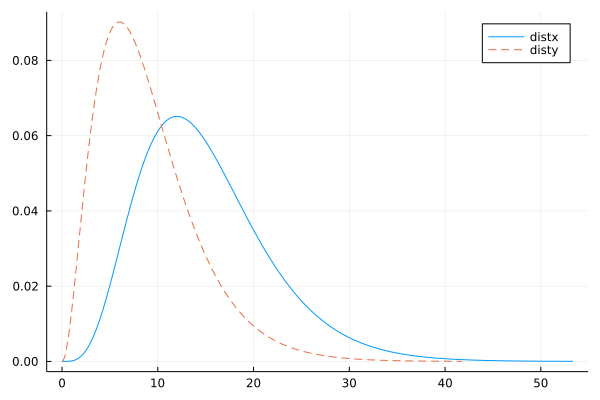

In [8]:
distx = Gamma(5, 3)
disty = Gamma(3, 3)
@show Δμ_true = mean(distx) - mean(disty)
plot(distx; label="distx")
plot!(disty; label="disty", ls=:dash)

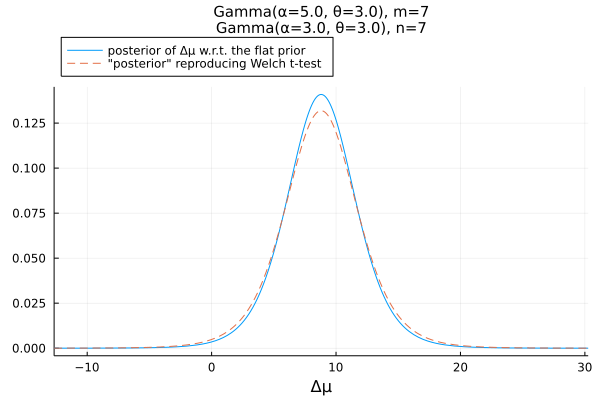

In [9]:
plot_bayesian_welch(distx, 7, disty, 7)

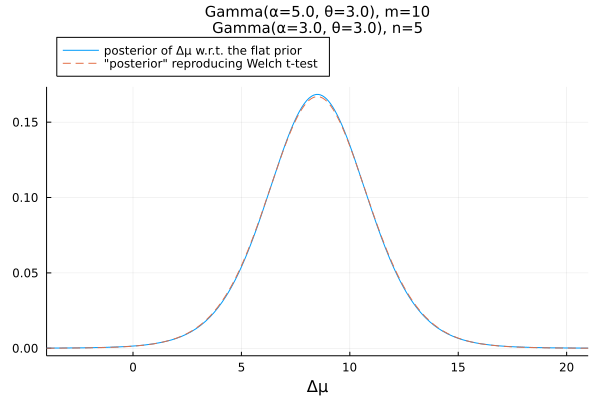

In [10]:
plot_bayesian_welch(distx, 10, disty, 5)

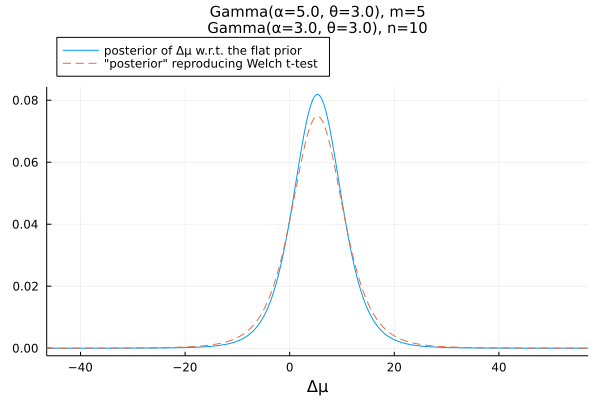

In [11]:
plot_bayesian_welch(distx, 5, disty, 10)

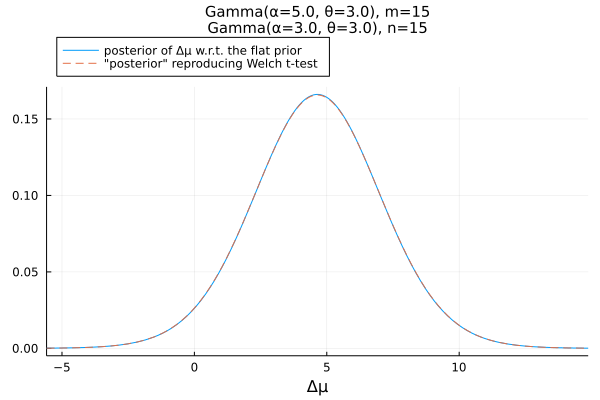

In [12]:
plot_bayesian_welch(distx, 15, disty, 15)

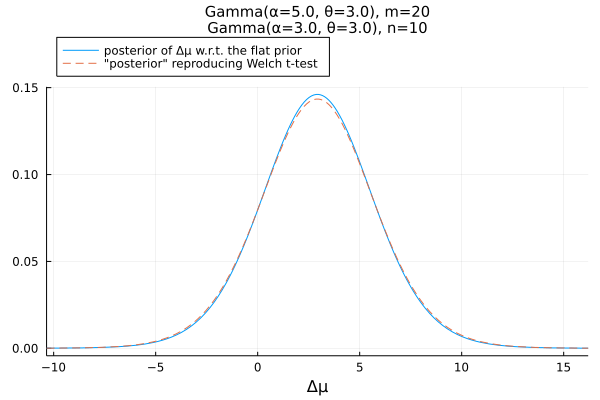

In [13]:
plot_bayesian_welch(distx, 20, disty, 10)

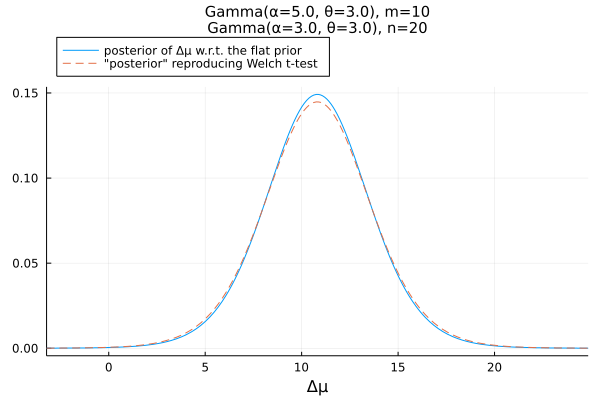

In [14]:
plot_bayesian_welch(distx, 10, disty, 20)

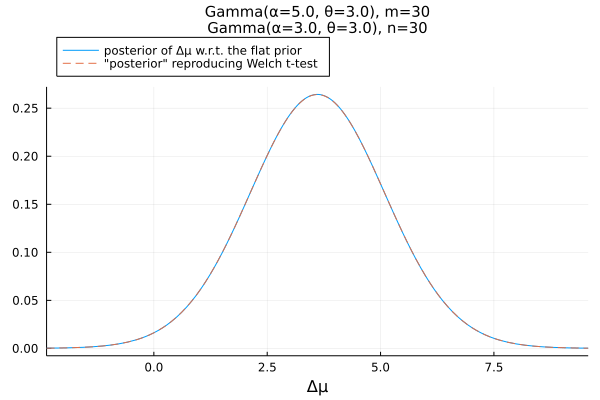

In [15]:
plot_bayesian_welch(distx, 30, disty, 30)

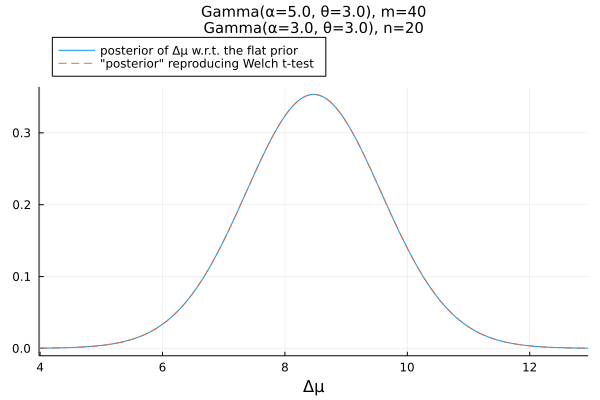

In [16]:
plot_bayesian_welch(distx, 40, disty, 20)

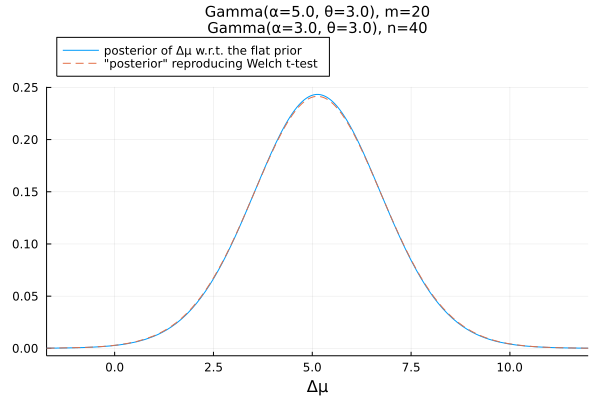

In [17]:
plot_bayesian_welch(distx, 20, disty, 40)